In [3]:
import numpy as np
from celerite.terms import Matern32Term, RealTerm
from mind_the_gaps.models.celerite_models import Lorentzian
from mind_the_gaps.simulator import Simulator
from mind_the_gaps.lightcurves import GappyLightcurve
import matplotlib.pyplot as plt
from mind_the_gaps.gpmodelling import GPModelling
from mind_the_gaps.stats import aicc
from scipy.stats import norm, ks_1samp
import corner
plt.rcParams['figure.figsize'] = [16, 8]
np.random.seed(10)

# Let's first generate a lightcurve with a complex PSD, a combination of a DRW, Matern-3/2 and a QPO (Lorentzian)

log variance of the QPO: 4.61, log_Q: 4.38, log omega: -1.38


/Users/oliviergilbert/Library/Python/3.9/lib/python/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


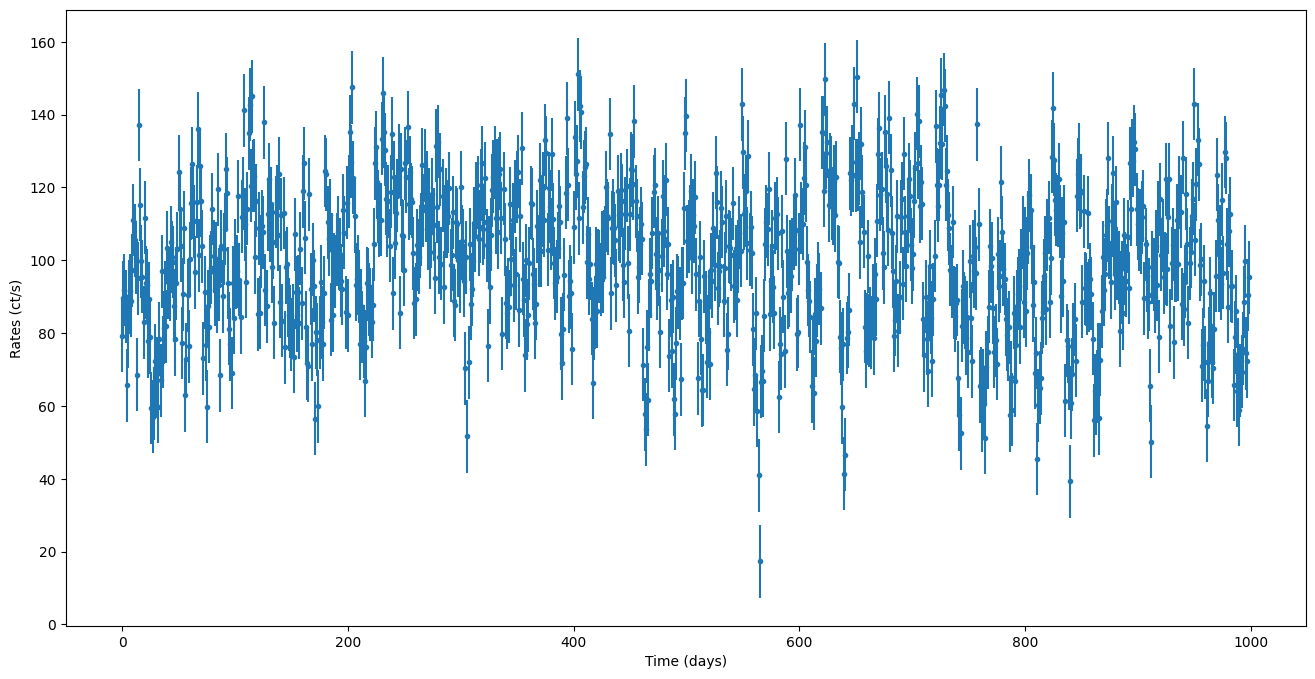

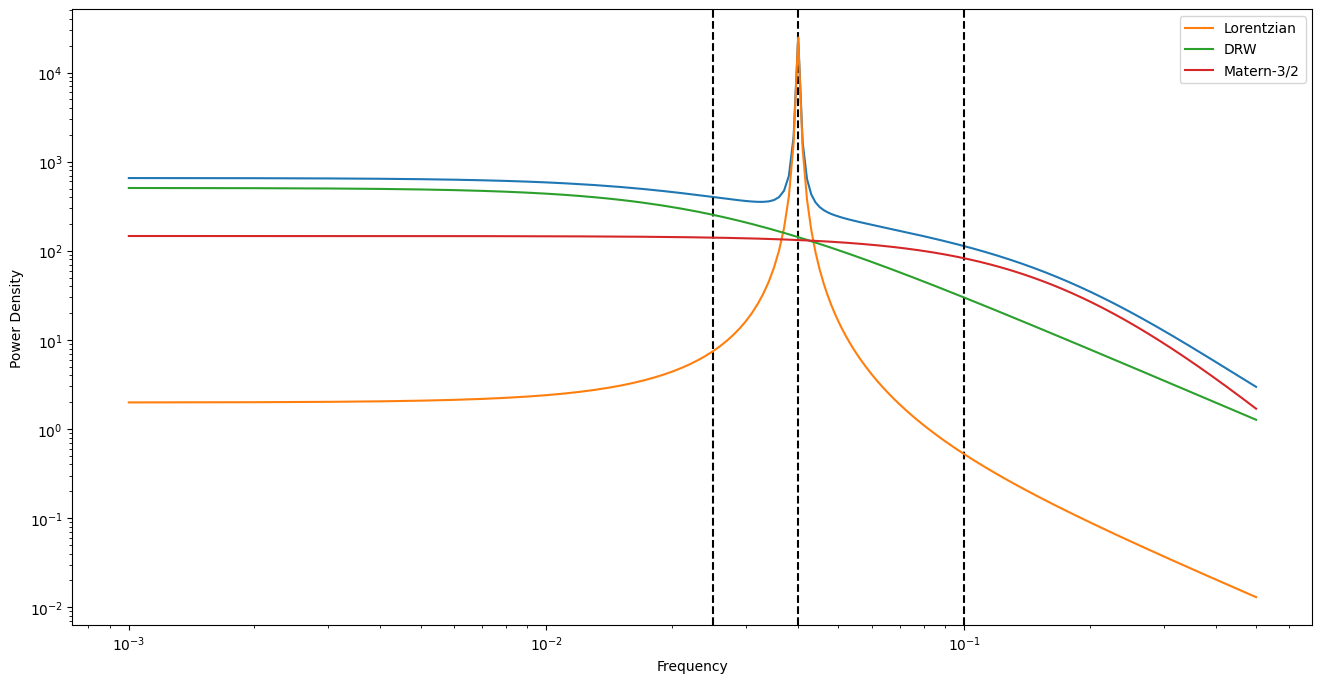

In [ ]:
np.random.seed(10)
times  = np.arange(0, 1000)
exposure = np.diff(times)[0]

P_qpo = 25 # period of the QPO
w = 2 * np.pi / P_qpo
mean = 100
rms = 0.1
variance_drw = (mean * rms) ** 2  # variance of the DRW (bending powerlaw)
P_drw = 40
w_bend = 2 * np.pi / P_drw # angular frequency of the DRW or Bending Powerlaw
# Define starting parameters
log_variance_qpo = np.log(variance_drw)
log_sigma_matern = np.log(np.sqrt(variance_drw))
P_matern = 10
log_rho_matern =  np.log(P_matern / 2 / np.pi)
Q = 80 # coherence
log_Q = np.log(Q)
log_d = np.log(w)
print(f"log variance of the QPO: {log_variance_qpo:.2f}, log_Q: {log_Q:.2f}, log omega: {log_d:.2f}")

labels = ["Lorentzian", "DRW", "Matern-3/2"]
# You can also use Lorentzian from models.celerite_models (which is defined in terms of variance, Q and omega)
kernel = Lorentzian(log_S0=log_variance_qpo, log_Q=np.log(Q), log_omega0=log_d) \
     + RealTerm(log_a=np.log(variance_drw), log_c=np.log(w_bend)) + Matern32Term(log_sigma_matern, 
                                                                                log_rho_matern, eps=1e-8)
truth = kernel.get_parameter_vector()
psd_model = kernel.get_psd

# create simulator object with Gaussian noise
simulator = Simulator(psd_model, times, np.ones(len(times)) * exposure, mean, pdf="Gaussian", 
                      sigma_noise=10, extension_factor = 2)

# simulate noiseless count rates from the PSD, make the initial lightcurve 2 times as long as the original times
countrates = simulator.generate_lightcurve()
# add (Poisson) noise
noisy_countrates, dy = simulator.add_noise(countrates)
input_lc = GappyLightcurve(times, noisy_countrates, dy, exposures=exposure)

fig = plt.figure()
plt.errorbar(times, noisy_countrates, yerr=dy, ls="None", marker=".")
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")

# plot PSD
df = 1 / input_lc.duration
nyquist = 1 / (2 * exposure)
freqs = np.arange(df, nyquist, df)
fig = plt.figure()
# remember angular freqs for the PSD models
plt.plot(freqs, psd_model(2 * np.pi * freqs))
for p in [P_qpo, P_drw, P_matern]:
    plt.axvline(1 / p, ls="--", color="black")

plt.xlabel("Frequency")
plt.ylabel("Power Density")
plt.xscale("log")
plt.yscale("log")
for i, term in enumerate(kernel.terms):
    plt.plot(freqs, term.get_psd(2 * np.pi * freqs), label=labels[i])
plt.legend()

lc_variance = np.var(input_lc.y)

Dummy methods to construct reasonable parameter bounds

In [24]:
def bounds_variance(variance, margin=15):
    return np.log(variance/margin), np.log(variance * margin)

def bounds_bend(duration, dt):
    nyquist = 1 / (2 * dt)
    return np.log(2 * np.pi/duration), np.log(nyquist * 2 * np.pi)

# Define models to be tested and their bounds based on the data

In [25]:
variance_bounds = bounds_variance(lc_variance)
print(variance_bounds)
bend_bounds = bounds_bend(input_lc.duration, exposure)
print(bend_bounds)
sigma_bounds = bounds_variance(np.sqrt(lc_variance))
timescale_bounds = ((np.log(exposure), np.log(input_lc.duration)))
print(timescale_bounds)
# limit Q lower bound to "periodic" components
Q_bounds = (np.log(1.5), np.log(1000))

log_var = np.log(lc_variance)
realterm = RealTerm(log_var, np.log(2 * np.pi / 50), bounds=[variance_bounds, bend_bounds])
lorentzian = Lorentzian(log_var, np.log(100), np.log(2 * np.pi/10), 
                     bounds=[variance_bounds, Q_bounds, bend_bounds])
matern = Matern32Term(np.log(np.sqrt(lc_variance)), np.log(10), bounds=[sigma_bounds, timescale_bounds], 
                      eps=1e-8)
import copy

models = [copy.deepcopy(realterm), 
          copy.deepcopy(matern),
         copy.deepcopy(lorentzian) + copy.deepcopy(realterm),
         copy.deepcopy(lorentzian) + copy.deepcopy(realterm) + copy.deepcopy(matern)
          ,]
for model in models:
    print(model)

(3.291298587594253, 8.707398989798673)
(-5.068877712239209, 1.1447298858494002)
(0.0, 6.906754778648554)
RealTerm(5.999348788696463, -2.0741459390188006)
Matern32Term(2.9996743943482316, 2.302585092994046, eps=1e-08)
(Lorentzian(5.999348788696463, 4.605170185988092, -0.46470802658470023) + RealTerm(5.999348788696463, -2.0741459390188006))
(Lorentzian(5.999348788696463, 4.605170185988092, -0.46470802658470023) + RealTerm(5.999348788696463, -2.0741459390188006) + Matern32Term(2.9996743943482316, 2.302585092994046, eps=1e-08))


# Derive AICc and p-values for the standarized residuals following a normal (0, 1) distribution

In [26]:
cpus = 12
aiccs = []
pvalues = []
gps = []
for kernel in models:
    print(kernel)
    print("------------------------------------------------------------------")
    gp = GPModelling(input_lc, kernel)
    # here we first minimize the likelihood and then run a small MCMC to ensure we find the maximum of the loglikelihood
    gp.derive_posteriors(fit=True, max_steps=2000, walkers=2 * cpus, cores=cpus, progress=False)
    best_pars = gp.max_parameters
    gp.gp.set_parameter_vector(best_pars)
    std_res = gp.standarized_residuals()
    pvalue = ks_1samp(std_res, norm.cdf).pvalue
    AICc = aicc(gp.max_loglikelihood, k=gp.k, n=input_lc.n)
    print(f"p-value:{pvalue:.3f} | AICC: {AICc:.2f}")
    pvalues.append(pvalue)
    aiccs.append(AICc)
    gps.append(gp)
    

RealTerm(5.999348788696463, -2.0741459390188006)
------------------------------------------------------------------
p-value:0.906 | AICC: 8298.59
Matern32Term(2.9996743943482316, 2.302585092994046, eps=1e-08)
------------------------------------------------------------------


/Users/oliviergilbert/Desktop/SMBH-Binaries-GPs/mind_the_gaps/gpmodelling.py:209: UserWarning: The chains did not converge after 2000 iterations!
  warnings.warn(f"The chains did not converge after {sampler.iteration} iterations!")


p-value:0.000 | AICC: 8306.97
(Lorentzian(5.999348788696463, 4.605170185988092, -0.46470802658470023) + RealTerm(5.999348788696463, -2.0741459390188006))
------------------------------------------------------------------
p-value:0.054 | AICC: 8236.64
(Lorentzian(5.999348788696463, 4.605170185988092, -0.46470802658470023) + RealTerm(5.999348788696463, -2.0741459390188006) + Matern32Term(2.9996743943482316, 2.302585092994046, eps=1e-08))
------------------------------------------------------------------
p-value:0.172 | AICC: 8236.52


# Finally our best-fit model is that which minimizes the AICc

[ 4.989573    4.73822997 -1.37450692  5.09305879 -1.02578968  1.73559203
  3.95019052]
Best model (Lorentzian(4.989572995510703, 4.738229969647853, -1.3745069203954556) + RealTerm(5.093058792471282, -1.0257896803136315) + Matern32Term(1.7355920301009526, 3.9501905237184243, eps=1e-08)) has a p-value: 0.172
[ 4.989573    4.73822997 -1.37450692  5.09305879 -1.02578968  1.73559203
  3.95019052]


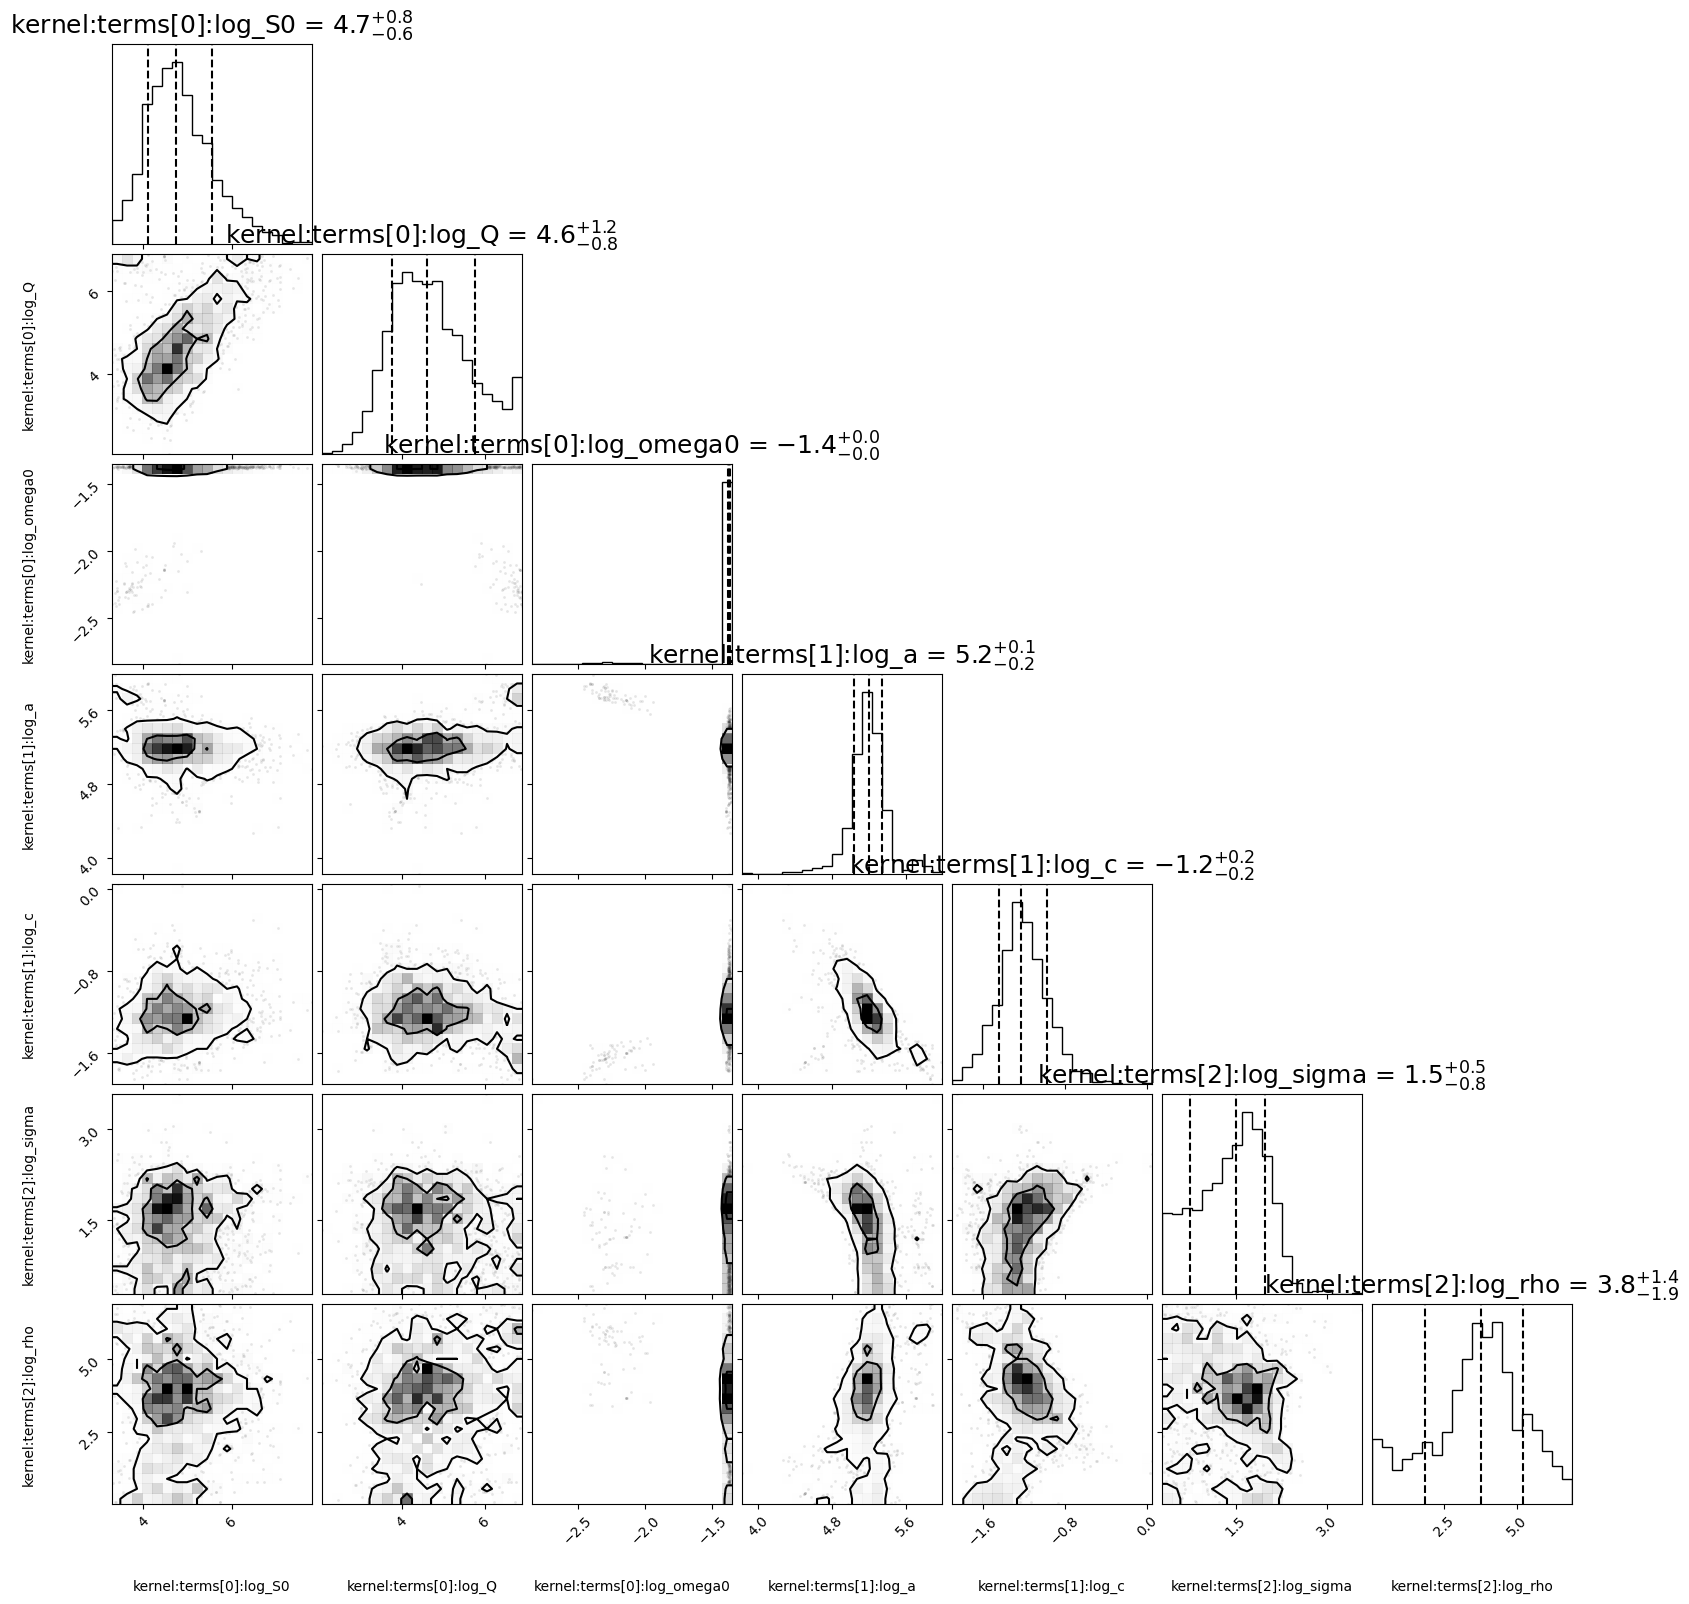

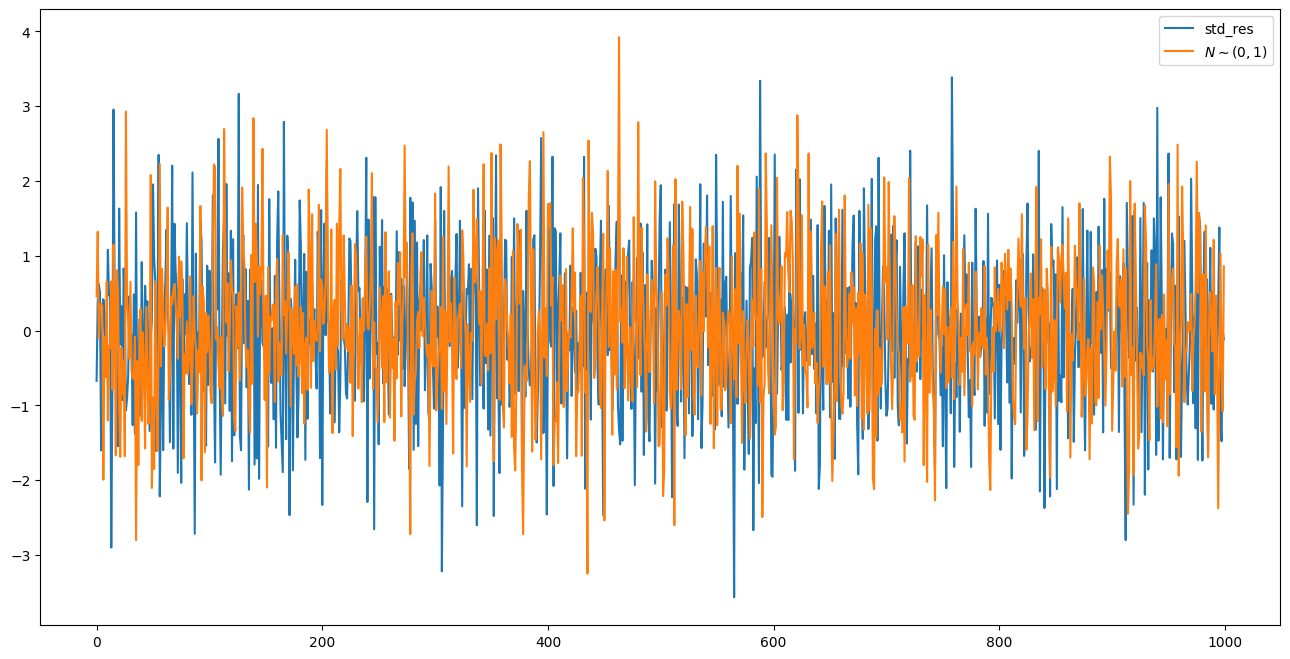

KS 2-samp : 0.31760697092388124 \pm 0.19603394780965644
KstestResult(statistic=0.054, pvalue=0.1082872208757189, statistic_location=-0.9732174710676629, statistic_sign=-1)
KstestResult(statistic=0.034838974734449996, pvalue=0.17232978925220788, statistic_location=-0.9378489318999533, statistic_sign=1)


[]

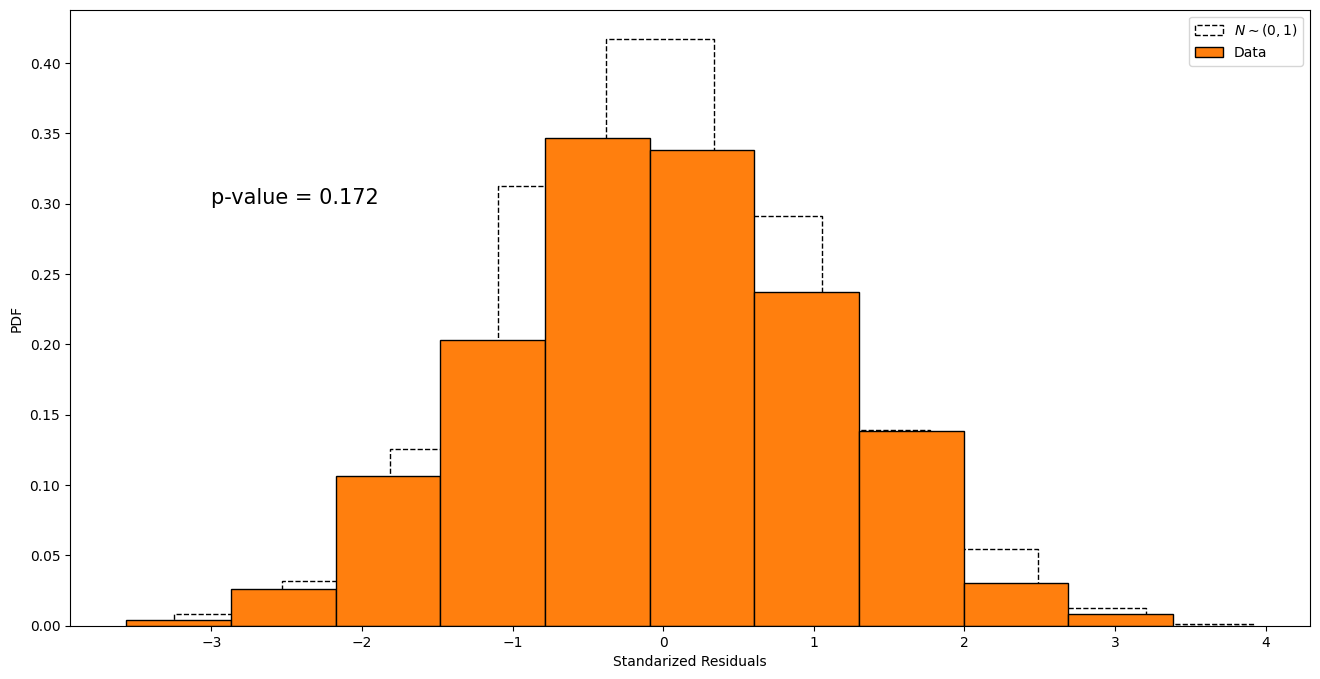

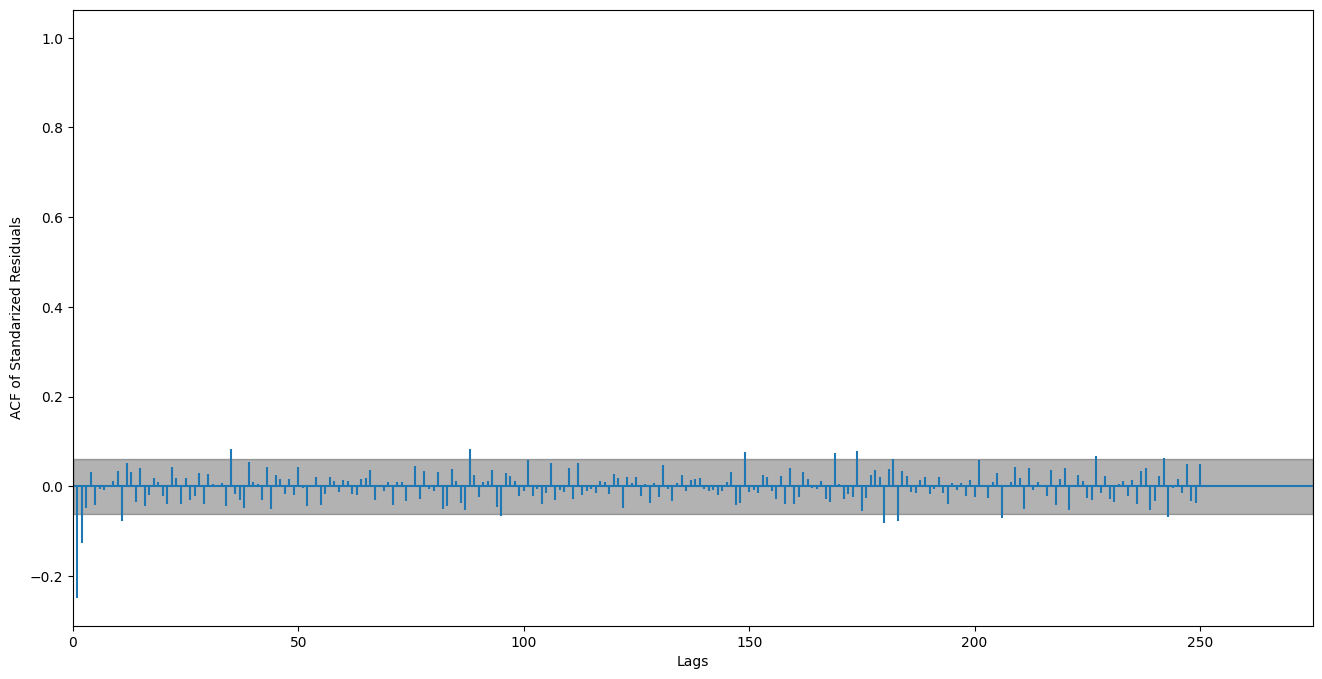

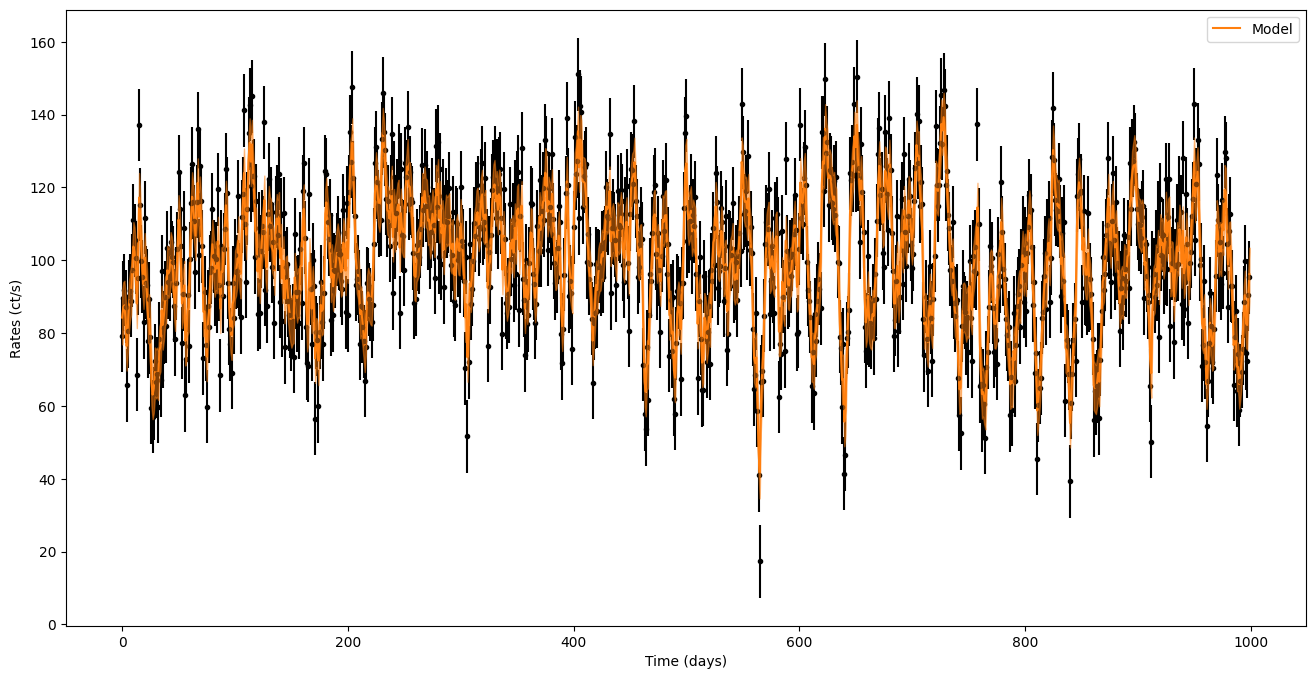

In [ ]:
best_gp = gps[np.argmin(aiccs)]
print(best_gp.max_parameters)
print(f"Best model {models[np.argmin(aiccs)]} has a p-value: {pvalues[np.argmin(aiccs)]:.3f}")
corner_fig = corner.corner(best_gp.mcmc_samples, labels=best_gp.gp.get_parameter_names(), 
                           title_fmt='.1f',
                            quantiles=[0.16, 0.5, 0.84], show_titles=True,
                            title_kwargs={"fontsize": 18}, max_n_ticks=3, labelpad=0.08,
                            levels=(1 - np.exp(-0.5), 1 - np.exp(-0.5 * 2 ** 2))) # plots 1 and 2 sigma levels

#plt.savefig("corner.png")
# 
best_gp.gp.set_parameter_vector(best_gp.max_parameters)
print(best_gp.gp.get_parameter_vector())
pred_mean, pred_var = best_gp.gp.predict(input_lc.y, return_var=True)
 # standarized residuals
plt.figure()
std_res = best_gp.standarized_residuals()
from scipy.stats import ks_2samp, norm
normal_distribution_sample = norm.rvs(size=len(std_res))
plt.plot(std_res, label="std_res")
plt.plot(normal_distribution_sample, label="$N\sim(0, 1)$")
plt.legend()
plt.show()
pvals = []
for i in range(1000):
    pvals.append(ks_2samp(norm.rvs(size=len(std_res)), std_res).pvalue)
print(f"My KS 2-samp : {np.mean(pvals)} \pm {np.std(pvals)}")
print(ks_2samp(normal_distribution_sample, std_res))
print(ks_1samp(std_res, cdf=norm.cdf))

plt.figure()
plt.hist(normal_distribution_sample, edgecolor="black" , ls="--",
         facecolor="None", density=True, label="$N\sim(0, 1)$")
plt.hist(std_res, density="True", edgecolor="black", label="Data")
plt.text(-3,0.3, f"p-value = {pvalues[np.argmin(aiccs)]:.3f}", fontsize=15)
plt.xlabel("Standarized Residuals")
plt.ylabel("PDF")
plt.legend()
#plt.savefig("std_res.png")
# ACF
plt.figure()
plt.acorr(std_res, maxlags=len(std_res) // 4 )
plt.xlim(0)
# 2 sigma
plt.axhspan(-1.96 / np.sqrt(len(std_res)), 1.96 / np.sqrt(len(std_res)), alpha=0.3, color="black")
plt.ylabel("ACF of Standarized Residuals")
plt.xlabel("Lags")
#plt.savefig("acf.png")
# best-fit model
fig = plt.figure()
plt.errorbar(times, noisy_countrates, yerr=dy, ls="None", marker=".", color="black")
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")
plt.plot(times, pred_mean, label="Model", color="C1")
plt.fill_between(times, pred_mean - np.sqrt(pred_var), pred_mean + np.sqrt(pred_var), 
                 zorder=10, color="C1", alpha=0.5)
plt.legend()
plt.plot()
#plt.savefig("model.png")